In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras.applications import ResNet50, EfficientNetB0
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard
from keras import Sequential, Model
import tensorflow as tf
import numpy as np
import logging
import os

In [2]:
n = 6
i1 = n - 1
i2 = n + 29
i3 = n + 59

In [3]:
data_dir = 'C:/Users/Admin/Desktop/іваночка_3_курс/2 семестр/нейронки/train'
classes = sorted(os.listdir(data_dir))
#selected_classes = [classes[i1], classes[i2], classes[i3]]
classes

['beet_salad', 'escargots', 'mussels']

In [4]:
train_data = []
test_data = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    cls_images = [os.path.join(cls, img) for img in os.listdir(cls_path)]
    train, test = train_test_split(cls_images, test_size=0.2, random_state=42)
    train_data.extend([(cls, img) for img in train])
    test_data.extend([(cls, img) for img in test])

train_df = pd.DataFrame(train_data, columns=['class', 'image'])
test_df = pd.DataFrame(test_data, columns=['class', 'image'])

In [46]:
img_size = (224, 224)
batch_size = 3

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_gen = train_datagen.flow_from_dataframe(train_df, directory=data_dir, x_col='image', y_col='class', target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data_gen = test_datagen.flow_from_dataframe(test_df, directory=data_dir, x_col='image', y_col='class', target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 180 validated image filenames belonging to 3 classes.
Found 45 validated image filenames belonging to 3 classes.


In [34]:
def init_cnn_model(class_num, input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),        
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(class_num, activation='softmax')
    ])    
    return model

In [35]:
def init_resnet_model(class_num, input_shape, fine_tuning):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)   
    for layer in base_model.layers:
        layer.trainable = False    
    if fine_tuning:
        for layer in base_model.layers[:-10]:
            layer.trainable = True   
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(class_num, activation='softmax')(x)    
    return Model(inputs=base_model.input, outputs=predictions)

In [36]:
def init_efficientnet_model(class_num, input_shape, fine_tuning):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    if fine_tuning:
        for layer in base_model.layers[:-10]:
            layer.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(class_num, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions)

In [37]:
def tensorboard_cb(model):
    log_dir = "logs/" + model
    callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
    print("tensorboard_cb: " + log_dir)
    return callback

In [47]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

CLASS_NUM = 3
INPUT_SHAPE = (img_size[0], img_size[1], CLASS_NUM)
EPOCHS = 10
TRAIN_SIZE = 180
VAL_SIZE = 45


    
cnn_model_adam = init_cnn_model(CLASS_NUM, INPUT_SHAPE)
cnn_model_adam.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_history_adam = cnn_model_adam.fit(train_data_gen, 
                                          steps_per_epoch=int(np.ceil(TRAIN_SIZE / float(batch_size))), 
                                          epochs=EPOCHS, 
                                          validation_data=val_data_gen, 
                                          validation_steps=int(np.ceil(VAL_SIZE / float(batch_size))), 
                                          callbacks=[tensorboard_cb('cnn_adam')])
    
    
    
resnet_model_adam = init_resnet_model(CLASS_NUM, INPUT_SHAPE, fine_tuning=False)
resnet_model_adam.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history_adam = resnet_model_adam.fit(train_data_gen, 
                                                steps_per_epoch=int(np.ceil(TRAIN_SIZE / float(batch_size))), 
                                                epochs=EPOCHS, 
                                                validation_data=val_data_gen, 
                                                validation_steps=int(np.ceil(VAL_SIZE / float(batch_size))), 
                                                callbacks=[tensorboard_cb('resnet_adam')])
    
resnet_model_sgd = init_resnet_model(CLASS_NUM, INPUT_SHAPE, fine_tuning=False)
resnet_model_sgd.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history_sgd = resnet_model_sgd.fit(train_data_gen, 
                                              steps_per_epoch=int(np.ceil(TRAIN_SIZE / float(batch_size))), 
                                              epochs=EPOCHS, 
                                              validation_data=val_data_gen, 
                                              validation_steps=int(np.ceil(VAL_SIZE / float(batch_size))), 
                                              callbacks=[tensorboard_cb('resnet_sgd')])
    
resnet_model_adam_ft = init_resnet_model(CLASS_NUM, INPUT_SHAPE, fine_tuning=True)
resnet_model_adam_ft.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history_adam_ft = resnet_model_adam_ft.fit(train_data_gen, 
                                                steps_per_epoch=int(np.ceil(TRAIN_SIZE / float(batch_size))), 
                                                epochs=EPOCHS, 
                                                validation_data=val_data_gen, 
                                                validation_steps=int(np.ceil(VAL_SIZE / float(batch_size))), 
                                                callbacks=[tensorboard_cb('resnet_adam_ft')])
    
    
    
efficientnet_model_adam = init_efficientnet_model(CLASS_NUM, INPUT_SHAPE, fine_tuning=False)
efficientnet_model_adam.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_history_adam = efficientnet_model_adam.fit(train_data_gen, 
                                                steps_per_epoch=int(np.ceil(TRAIN_SIZE / float(batch_size))), 
                                                epochs=EPOCHS, 
                                                validation_data=val_data_gen, 
                                                validation_steps=int(np.ceil(VAL_SIZE / float(batch_size))), 
                                                callbacks=[tensorboard_cb('efficientnet_adam')])
    
efficientnet_model_sgd = init_efficientnet_model(CLASS_NUM, INPUT_SHAPE, fine_tuning=False)
efficientnet_model_sgd.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_history_sgd = efficientnet_model_sgd.fit(train_data_gen, 
                                              steps_per_epoch=int(np.ceil(TRAIN_SIZE / float(batch_size))), 
                                              epochs=EPOCHS, 
                                              validation_data=val_data_gen, 
                                              validation_steps=int(np.ceil(VAL_SIZE / float(batch_size))), 
                                              callbacks=[tensorboard_cb('efficientnet_sgd')])
    
efficientnet_model_adam_ft = init_efficientnet_model(CLASS_NUM, INPUT_SHAPE, fine_tuning=True)
efficientnet_model_adam_ft.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_history_adam_ft = efficientnet_model_adam_ft.fit(train_data_gen, 
                                                steps_per_epoch=int(np.ceil(TRAIN_SIZE / float(batch_size))), 
                                                epochs=EPOCHS, 
                                                validation_data=val_data_gen, 
                                                validation_steps=int(np.ceil(VAL_SIZE / float(batch_size))), 
                                                callbacks=[tensorboard_cb('efficientnet_adam_ft')])


tensorboard_cb: logs/cnn_adam
Epoch 1/10
60/60 [==============================] - 35s 578ms/step - loss: 1.2827 - accuracy: 0.3389 - val_loss: 1.0979 - val_accuracy: 0.3333
Epoch 2/10
60/60 [==============================] - 41s 683ms/step - loss: 1.0961 - accuracy: 0.3333 - val_loss: 1.0862 - val_accuracy: 0.3333
Epoch 3/10
60/60 [==============================] - 34s 558ms/step - loss: 1.0936 - accuracy: 0.4278 - val_loss: 1.1179 - val_accuracy: 0.3556
Epoch 4/10
60/60 [==============================] - 30s 497ms/step - loss: 1.0950 - accuracy: 0.3444 - val_loss: 1.0592 - val_accuracy: 0.4889
Epoch 5/10
60/60 [==============================] - 30s 497ms/step - loss: 1.0635 - accuracy: 0.3778 - val_loss: 1.0213 - val_accuracy: 0.5111
Epoch 6/10
60/60 [==============================] - 29s 490ms/step - loss: 0.9711 - accuracy: 0.5111 - val_loss: 1.0252 - val_accuracy: 0.3333
Epoch 7/10
60/60 [==============================] - 30s 498ms/step - loss: 0.9304 - accuracy: 0.5278 - val_loss:

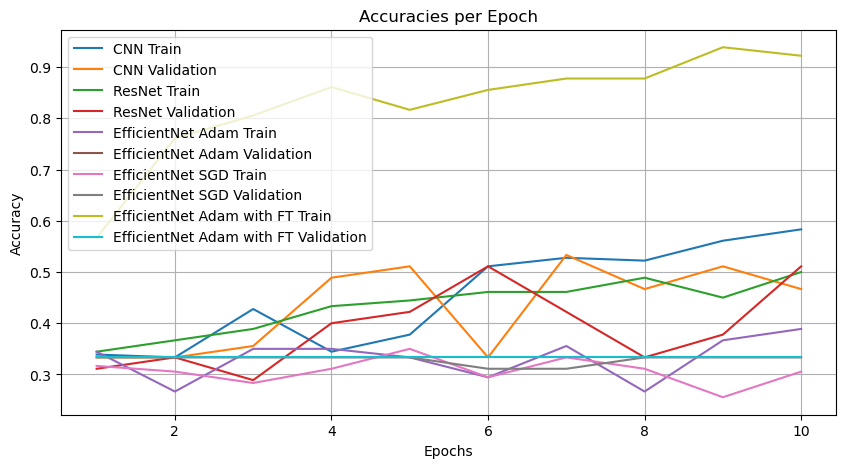

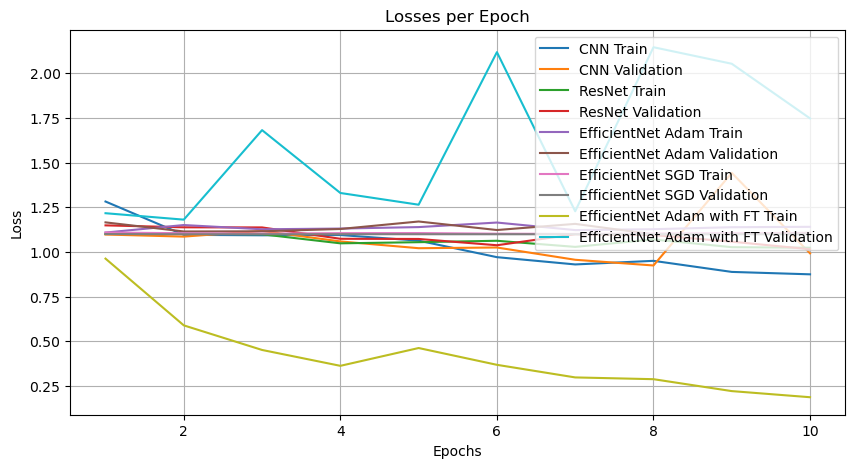

In [52]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from history objects
cnn_train_acc = cnn_history_adam.history['accuracy']
cnn_val_acc = cnn_history_adam.history['val_accuracy']
cnn_train_loss = cnn_history_adam.history['loss']
cnn_val_loss = cnn_history_adam.history['val_loss']

resnet_train_adam_acc = resnet_history_adam.history['accuracy']
resnet_val_adam_acc = resnet_history_adam.history['val_accuracy']
resnet_train_adam_loss = resnet_history_adam.history['loss']
resnet_val_adam_loss = resnet_history_adam.history['val_loss']

resnet_train_sgd_acc = resnet_history_sgd.history['accuracy']
resnet_val_sgd_acc = resnet_history_sgd.history['val_accuracy']
resnet_train_sgd_loss = resnet_history_sgd.history['loss']
resnet_val_sgd_loss = resnet_history_sgd.history['val_loss']

efficientnet_train_adam_acc = efficientnet_history_adam.history['accuracy']
efficientnet_val_adam_acc = efficientnet_history_adam.history['val_accuracy']
efficientnet_train_adam_loss = efficientnet_history_adam.history['loss']
efficientnet_val_adam_loss = efficientnet_history_adam.history['val_loss']

efficientnet_train_sgd_acc = efficientnet_history_sgd.history['accuracy']
efficientnet_val_sgd_acc = efficientnet_history_sgd.history['val_accuracy']
efficientnet_train_sgd_loss = efficientnet_history_sgd.history['loss']
efficientnet_val_sgd_loss = efficientnet_history_sgd.history['val_loss']

efficientnet_train_adam_ft_acc = efficientnet_history_adam_ft.history['accuracy']
efficientnet_val_adam_ft_acc = efficientnet_history_adam_ft.history['val_accuracy']
efficientnet_train_adam_ft_loss = efficientnet_history_adam_ft.history['loss']
efficientnet_val_adam_ft_loss = efficientnet_history_adam_ft.history['val_loss']

# Plot accuracies per epoch
plt.figure(figsize=(10, 5))
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, cnn_train_acc, label='CNN Train')
plt.plot(epochs, cnn_val_acc, label='CNN Validation')
plt.plot(epochs, resnet_train_acc, label='ResNet Train')
plt.plot(epochs, resnet_val_acc, label='ResNet Validation')
plt.plot(epochs, efficientnet_train_adam_acc, label='EfficientNet Adam Train')
plt.plot(epochs, efficientnet_val_adam_acc, label='EfficientNet Adam Validation')
plt.plot(epochs, efficientnet_train_sgd_acc, label='EfficientNet SGD Train')
plt.plot(epochs, efficientnet_val_sgd_acc, label='EfficientNet SGD Validation')
plt.plot(epochs, efficientnet_train_adam_ft_acc, label='EfficientNet Adam with FT Train')
plt.plot(epochs, efficientnet_val_adam_ft_acc, label='EfficientNet Adam with FT Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies per Epoch')
plt.grid()
plt.legend()
plt.show()

# Plot losses per epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs, cnn_train_loss, label='CNN Train')
plt.plot(epochs, cnn_val_loss, label='CNN Validation')
plt.plot(epochs, resnet_train_loss, label='ResNet Train')
plt.plot(epochs, resnet_val_loss, label='ResNet Validation')
plt.plot(epochs, efficientnet_train_adam_loss, label='EfficientNet Adam Train')
plt.plot(epochs, efficientnet_val_adam_loss, label='EfficientNet Adam Validation')
plt.plot(epochs, efficientnet_train_sgd_loss, label='EfficientNet SGD Train')
plt.plot(epochs, efficientnet_val_sgd_loss, label='EfficientNet SGD Validation')
plt.plot(epochs, efficientnet_train_adam_ft_loss, label='EfficientNet Adam with FT Train')
plt.plot(epochs, efficientnet_val_adam_ft_loss, label='EfficientNet Adam with FT Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses per Epoch')
plt.grid()
plt.legend()
plt.show()